## Business Case Problem Statement

To help Jamboree-the Education Consultant, in understanding which key factors majorly contributes in graduate admissions and is there any correlation among themselves.\
Creating a predictive model of one's chances of getting admission with features like: GRE and TOEFL Score, University Ranking, Contribution towards Research, CGPA, LOE and SOP

## Importing Libraries and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, chi2_contingency, f_oneway, pearsonr, spearmanr, shapiro
from category_encoders import target_encoder
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline

In [3]:
jamb_df = pd.read_csv('Jamboree_Admission.csv')
jamb_df.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


## Exploratory Data Analysis

In [4]:
jamb_df = jamb_df[jamb_df.columns.drop('Serial No.')]
jamb_df.head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
5,330,115,5,4.5,3.0,9.34,1,0.90
6,321,109,3,3.0,4.0,8.20,1,0.75
7,308,101,2,3.0,4.0,7.90,0,0.68
8,302,102,1,2.0,1.5,8.00,0,0.50
9,323,108,3,3.5,3.0,8.60,0,0.45


In [5]:
jamb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [6]:
jamb_df.duplicated().sum()

0

In [7]:
jamb_df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [8]:
jamb_df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [9]:
col_names = jamb_df.columns.to_list()
col_names

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR ',
 'CGPA',
 'Research',
 'Chance of Admit ']

In [10]:
jamb_df.columns=[str.strip(x) for x in col_names]

In [11]:
col_names = jamb_df.columns.to_list()
col_names

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR',
 'CGPA',
 'Research',
 'Chance of Admit']

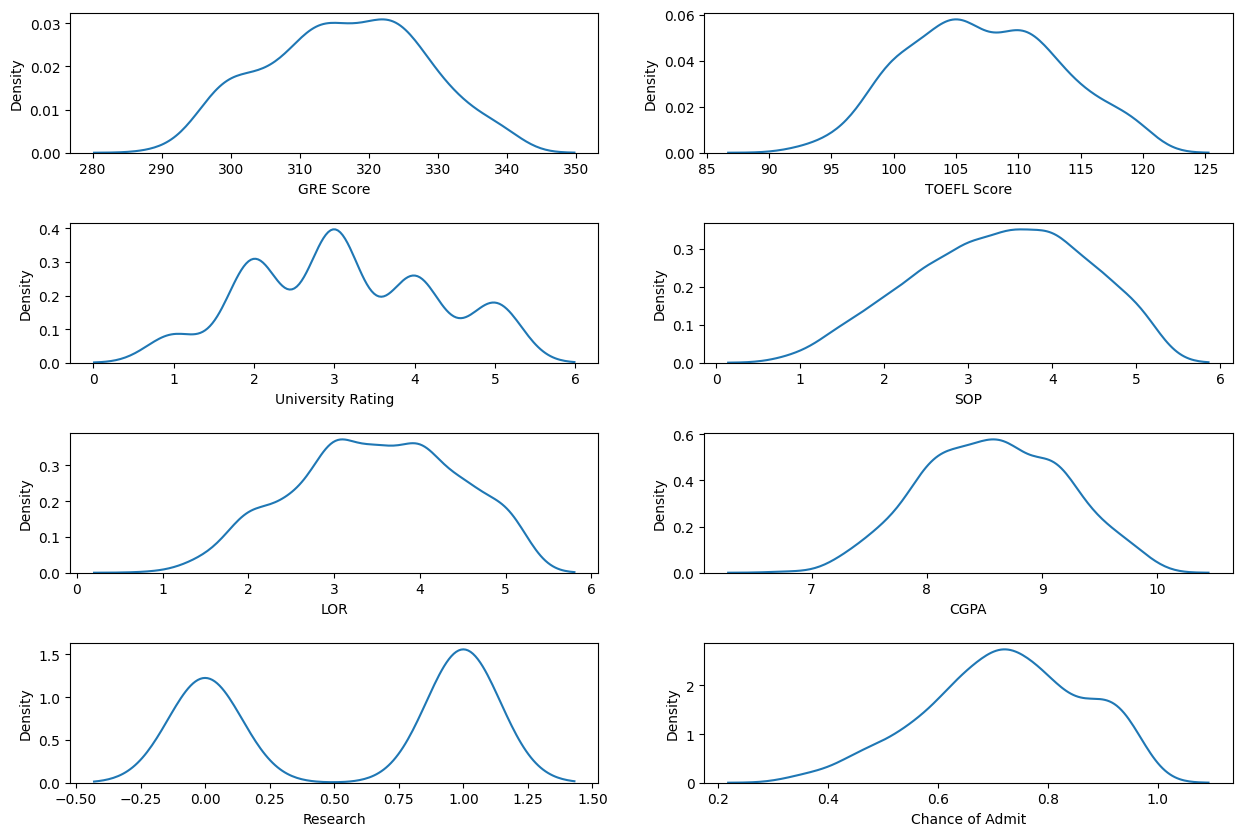

In [12]:
fig = plt.figure(figsize=(15,10))
for i in range(len(col_names)):
    plt.subplot(4,2,i+1)
    sns.kdeplot(data=jamb_df, x=col_names[i])
#     plt.title(col_names[i])
#     plt.xlabel(' ')
plt.subplots_adjust(hspace = .5)
plt.show()


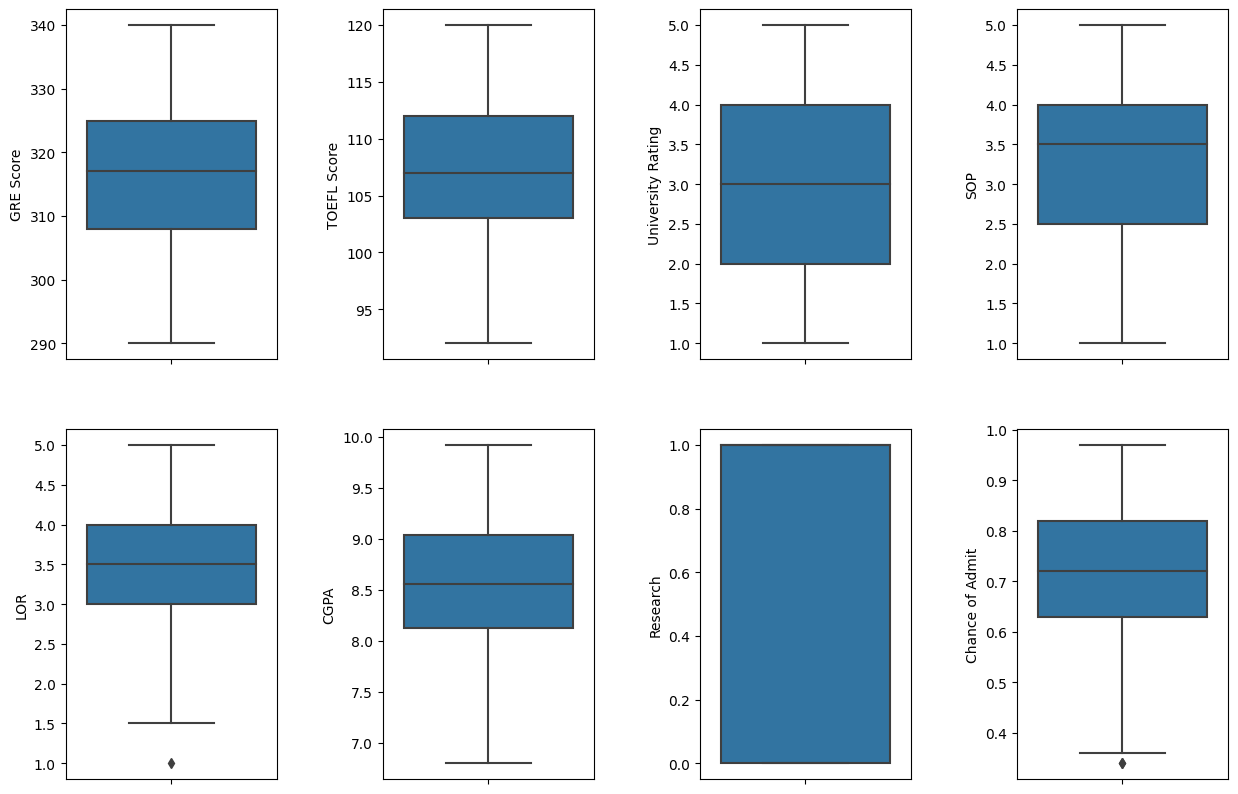

In [13]:
fig = plt.figure(figsize=(15,10))
for i in range(len(col_names)):
    plt.subplot(2,4,i+1)
    sns.boxplot(data=jamb_df, y=col_names[i])
    plt.subplots_adjust(wspace=0.5)
plt.show()

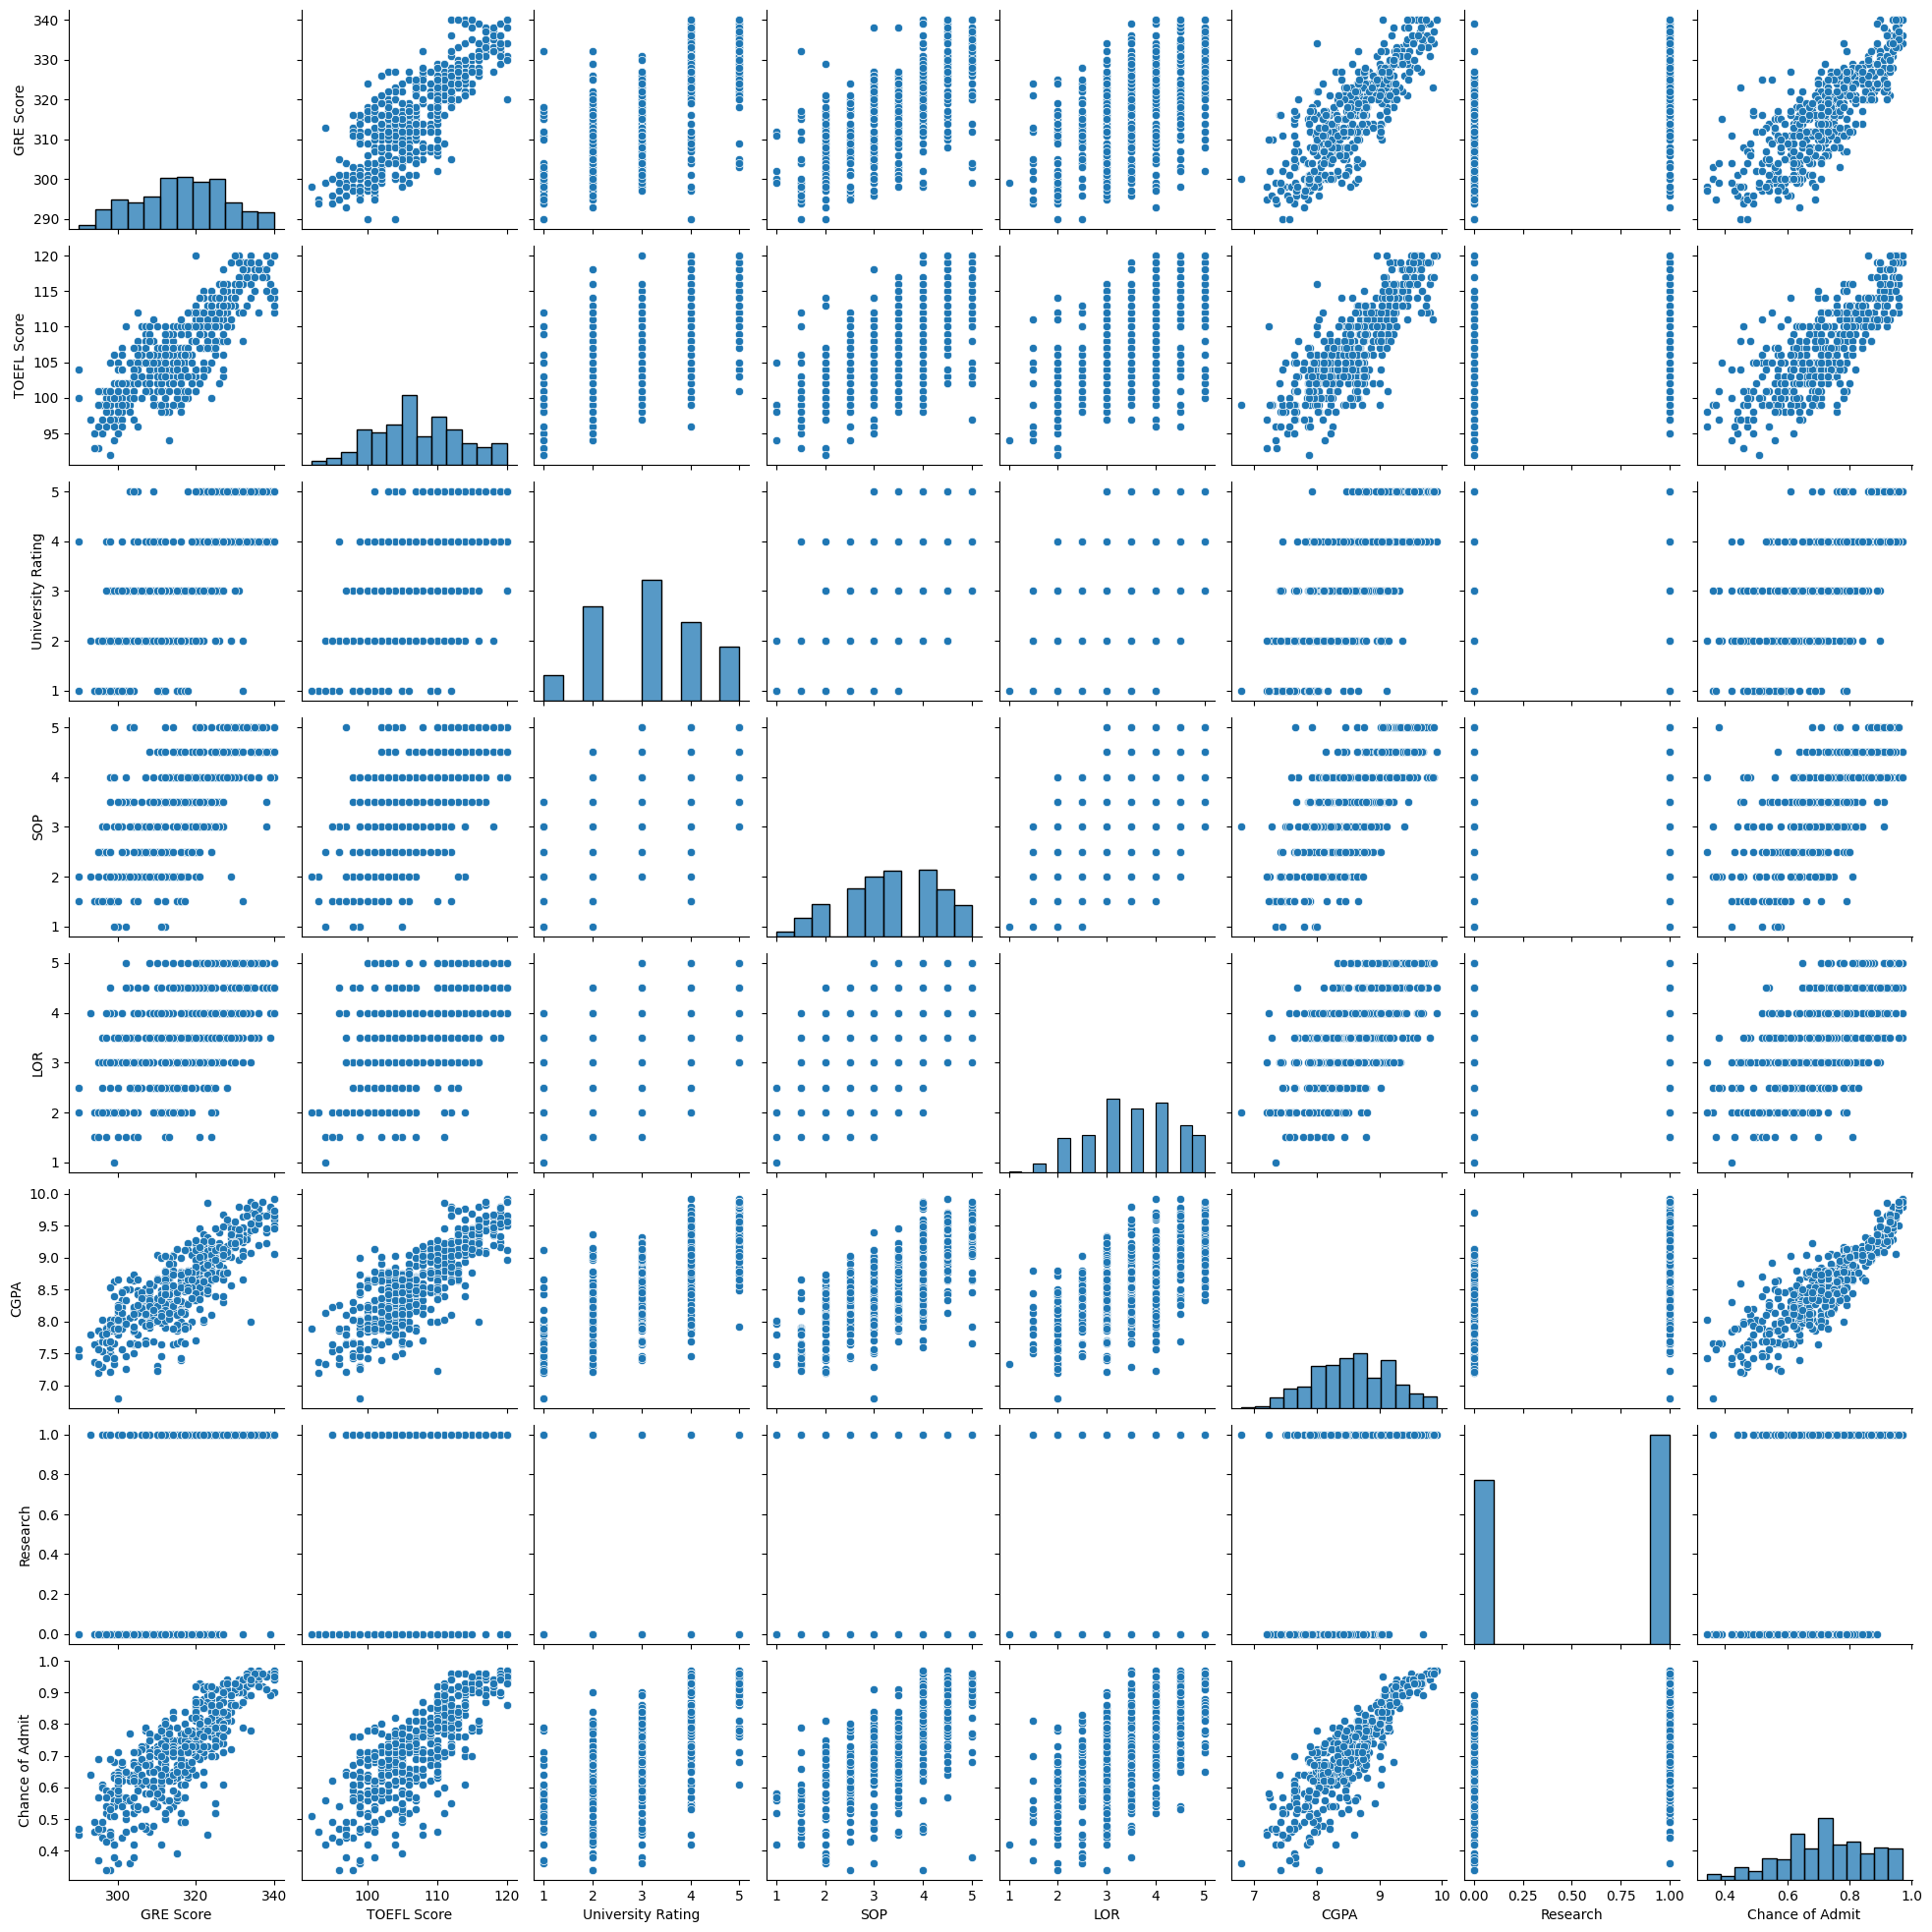

In [14]:
sns.pairplot(jamb_df)
plt.show()

In [15]:
spearmanr(jamb_df['GRE Score'], jamb_df['TOEFL Score'])

SignificanceResult(statistic=0.8238534081232208, pvalue=7.01498176501869e-125)

In [16]:
spearmanr(jamb_df['GRE Score'], jamb_df['CGPA'])

SignificanceResult(statistic=0.829250722579067, pvalue=6.272247768603649e-128)

In [17]:
np.corrcoef(jamb_df['GRE Score'], jamb_df['TOEFL Score'])[0,1]

0.8272004035317213

In [18]:
np.corrcoef(jamb_df['GRE Score'], jamb_df['CGPA'])[0,1]

0.8258779536403555

In [19]:
np.corrcoef(jamb_df['TOEFL Score'], jamb_df['CGPA'])[0,1]

0.8105735363036225

In [20]:
spearmanr(jamb_df['LOR'], jamb_df['SOP'])

SignificanceResult(statistic=0.6626528953712509, pvalue=1.5903224082563312e-64)

In [21]:
np.corrcoef(jamb_df['LOR'], jamb_df['SOP'])[0,1]

0.6637068525149349

In [22]:
spearmanr(jamb_df['LOR'], jamb_df['CGPA'])

SignificanceResult(statistic=0.6395632635309546, pvalue=7.306805480340624e-59)

In [23]:
np.corrcoef(jamb_df['LOR'], jamb_df['CGPA'])[0,1]

0.6374692057544709

### EDA Observation

1. Research being the categorical variable has two unique values
2. For rest of the variable Mean and Median is close, indicating data is not skewed due to outliers
3. Data is not duplicated
4. Data has no NaNs
5. No need for encoding as all the variables are numeric
6. GRE Score, TOEFL Score and CGPA are highly positive correlated
7. LOR and SOP is moderately correlated
8. LOR and CGPA is is moderetely correlated

## ML Modeling Flow

### Data Preparation - Split, Cleaning, Encoding and Scaling

In [24]:
x_jamb_df = jamb_df.drop('Chance of Admit', axis=1)
x_jamb_df.head(10)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
5,330,115,5,4.5,3.0,9.34,1
6,321,109,3,3.0,4.0,8.20,1
7,308,101,2,3.0,4.0,7.90,0
8,302,102,1,2.0,1.5,8.00,0
9,323,108,3,3.5,3.0,8.60,0


In [25]:
y_jamb_df = pd.DataFrame(jamb_df['Chance of Admit'])
y_jamb_df

,Chance of Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65
...,...
495,0.87
496,0.96
497,0.93
498,0.73


In [26]:
x_train_jamb, x_test_jamb, y_train_jamb, y_test_jamb = train_test_split(x_jamb_df, y_jamb_df, train_size=.8, random_state=2)
print('Original feature size:', x_jamb_df.shape)
print('Training feature size:', x_train_jamb.shape)
print('Test feature size:', x_test_jamb.shape)

print('Original Target size:', y_jamb_df.shape)
print('Training Target size:', y_train_jamb.shape)
print('Test Target size:', y_test_jamb.shape)


Original feature size: (500, 7)
Training feature size: (400, 7)
Test feature size: (100, 7)
Original Target size: (500, 1)
Training Target size: (400, 1)
Test Target size: (100, 1)


In [27]:
x_min_max_obj = MinMaxScaler()
y_min_max_obj = MinMaxScaler()

In [28]:
x_min_max_obj.fit(x_train_jamb)
y_min_max_obj.fit(y_train_jamb)

MinMaxScaler()

In [29]:
# dir(x_min_max_obj)

In [30]:
x_min_max_obj.data_max_

array([340.  , 120.  ,   5.  ,   5.  ,   5.  ,   9.92,   1.  ])

In [31]:
x_min_max_obj.data_range_

array([47.  , 27.  ,  4.  ,  4.  ,  4.  ,  3.12,  1.  ])

In [32]:
x_min_max_obj.data_min_

array([293. ,  93. ,   1. ,   1. ,   1. ,   6.8,   0. ])

In [33]:
x_train_scaled = pd.DataFrame(x_min_max_obj.transform(x_train_jamb), columns=x_train_jamb.columns)
y_train_scaled = pd.DataFrame(y_min_max_obj.transform(y_train_jamb), columns=y_train_jamb.columns)

x_test_scaled = pd.DataFrame(x_min_max_obj.transform(x_test_jamb), columns=x_train_jamb.columns)
y_test_scaled = pd.DataFrame(y_min_max_obj.transform(y_test_jamb), columns=y_train_jamb.columns)


In [34]:
x_train_scaled.head(5)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,0.489362,0.370370,0.25,0.250,0.875,0.621795,0.0
1,0.297872,0.444444,0.25,0.375,0.875,0.423077,1.0
2,0.659574,0.703704,0.75,0.750,0.375,0.416667,1.0
3,0.553191,0.629630,0.50,0.500,0.375,0.637821,0.0
4,0.702128,0.555556,0.50,0.500,0.625,0.669872,0.0


In [35]:
y_train_scaled.head(5)

,Chance of Admit
0,0.555556
1,0.523810
2,0.603175
3,0.603175
4,0.730159


### Checking Variance Inflation Factor to eliminate Multicollinearity

<Axes: >

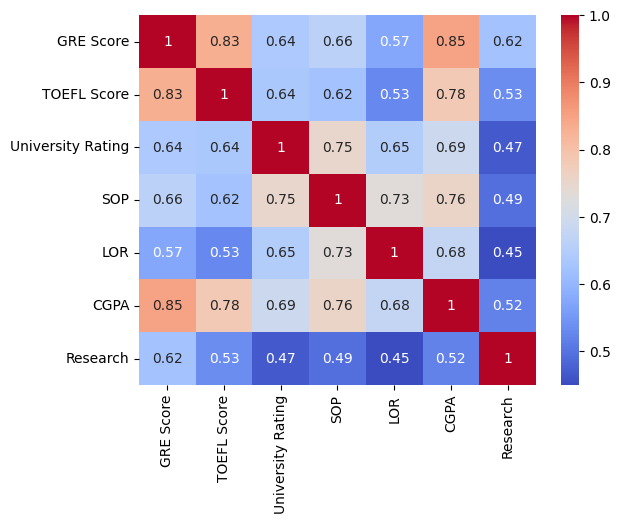

In [36]:
sns.heatmap(x_test_scaled.corr(method = 'spearman'), cmap='coolwarm', annot=True)

In [37]:
def elim_multicol(feature_list, df):
    vif = pd.DataFrame()
    vif['feature'] = feature_list
    vif['vif_score'] = [variance_inflation_factor(df[feature_list].values, i) for i in range(df[feature_list].shape[1])]
    vif.sort_values(by='vif_score', ascending=False, inplace=True)
    
    if vif['vif_score'][0] > 5:
        feature_list = vif['feature'][1:].to_list()
#         print(vif)
#         print('------------------------------------')
        vif = elim_multicol(feature_list, df)
    return vif

In [38]:
vif = elim_multicol(x_jamb_df.columns.tolist(), x_jamb_df)
vif

,feature,vif_score
1,Research,2.407952
0,TOEFL Score,2.407952


In [39]:
x_train_scaled = x_train_scaled[vif['feature']]
x_train_scaled

,Research,TOEFL Score
0,0.0,0.370370
1,1.0,0.444444
2,1.0,0.703704
3,0.0,0.629630
4,0.0,0.555556
...,...,...
395,1.0,0.851852
396,1.0,0.666667
397,1.0,0.074074
398,0.0,0.444444


In [40]:
x_test_scaled = x_test_scaled[vif['feature']]
x_test_scaled

,Research,TOEFL Score
0,1.0,0.925926
1,1.0,0.333333
2,0.0,0.407407
3,1.0,0.740741
4,0.0,0.222222
...,...,...
95,0.0,0.444444
96,0.0,0.407407
97,1.0,0.629630
98,1.0,0.629630


<function matplotlib.pyplot.show(close=None, block=None)>

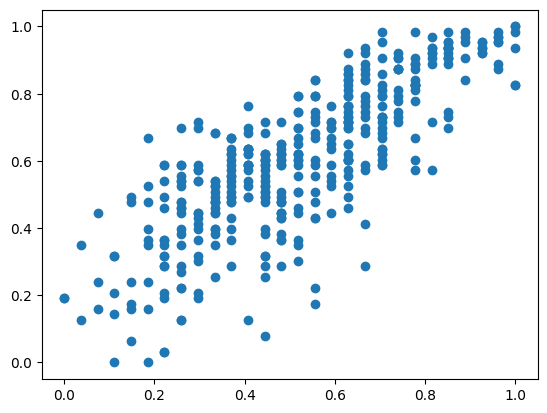

In [41]:
plt.scatter(x_train_scaled['TOEFL Score'], y_train_scaled)
plt.show

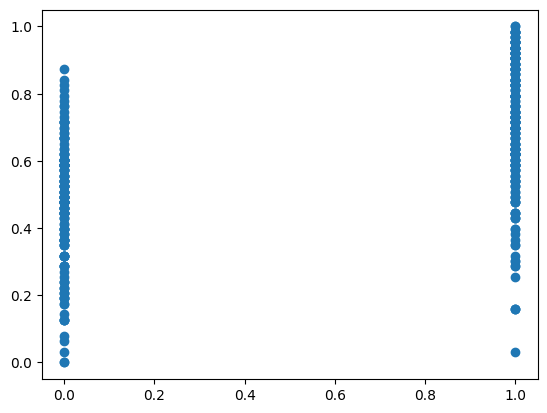

In [42]:
plt.scatter(x_train_scaled['Research'], y_train_scaled)

### VIF and Multicollinearity

Data is highly correlated and has a multicolinearity for independent Variables.\
Only 2 out of 7 features with moderate correlation can be carried forward to minimize multicollinearity.

### Creating Regression Model with Statsmodel Library

In [43]:
x_train_sm = sm.add_constant(x_train_scaled)
x_train_sm.head(4)

,const,Research,TOEFL Score
0,1.0,0.0,0.370370
1,1.0,1.0,0.444444
2,1.0,1.0,0.703704
3,1.0,0.0,0.629630


In [44]:
x_test_sm = sm.add_constant(x_test_scaled)
x_test_sm.head(4)

,const,Research,TOEFL Score
0,1.0,1.0,0.925926
1,1.0,1.0,0.333333
2,1.0,0.0,0.407407
3,1.0,1.0,0.740741


In [45]:
jamb_model = sm.OLS(y_train_scaled, x_train_sm).fit()
y_pred = pd.DataFrame(jamb_model.predict(x_test_sm), columns=y_test_scaled.columns)

In [46]:
jamb_model.params

const          0.186355
Research       0.102269
TOEFL Score    0.695451
dtype: float64

In [47]:
y_pred

,Chance of Admit
0,0.932559
1,0.520441
2,0.469687
3,0.803772
4,0.340900
...,...
95,0.495444
96,0.469687
97,0.726500
98,0.726500


In [48]:
jamb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance of Admit   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     434.0
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          1.23e-100
Time:                        20:15:56   Log-Likelihood:                 266.79
No. Observations:                 400   AIC:                            -527.6
Df Residuals:                     397   BIC:                            -515.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1864      0.016     11.742      0.000       0.155       0.218
Research        0.1023      0.014      7.270      0.000       0.075       0.130
TOEFL Score     0.6955      0.031     22.210      0.000       0.634       0.757
==============================================================================
Omnibus:                       37.930   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.588
Skew:                          -0.763   Prob(JB):                     7.65e-11
Kurtosis:                       3.685   Cond. No.                         7.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
res_error = y_test_scaled - y_pred

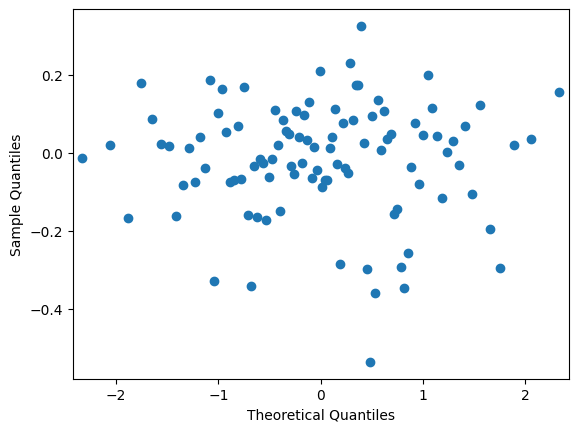

In [50]:
sm.qqplot(res_error)
plt.show()

In [51]:
shapiro(res_error)

ShapiroResult(statistic=0.9548119306564331, pvalue=0.0017455306369811296)

In [52]:
np.mean(res_error)

Chance of Admit   -0.016192
dtype: float64

<Axes: ylabel='Density'>

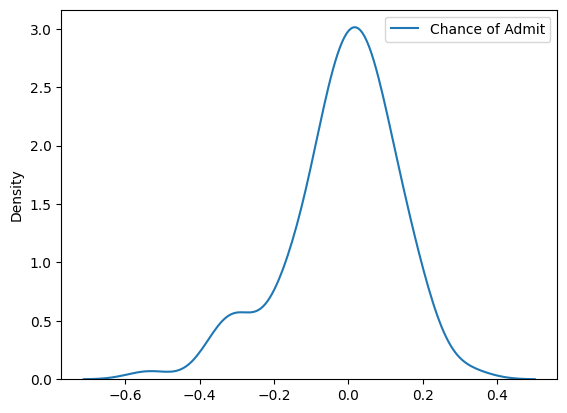

In [53]:
sns.kdeplot(res_error)

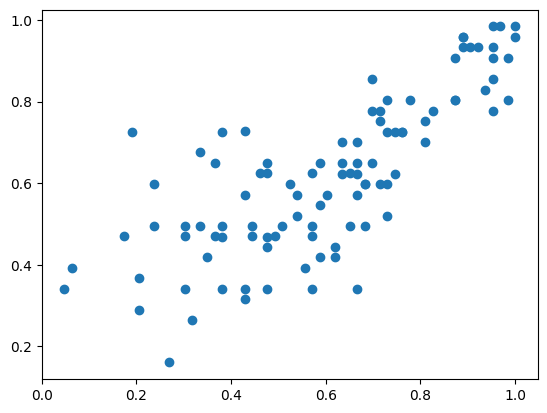

In [54]:
plt.scatter(y_test_scaled, y_pred)
plt.show()

In [55]:
jamb_model.resid

0      0.111626
1     -0.073903
2     -0.174840
3     -0.021057
4      0.157442
         ...   
395    0.071336
396    0.184251
397    0.104306
398   -0.177984
399    0.084537
Length: 400, dtype: float64

In [56]:
jamb_model.model.exog

array([[1.        , 0.        , 0.37037037],
       [1.        , 1.        , 0.44444444],
       [1.        , 1.        , 0.7037037 ],
       ...,
       [1.        , 1.        , 0.07407407],
       [1.        , 0.        , 0.44444444],
       [1.        , 1.        , 0.14814815]])

In [57]:
stat_val = het_white(jamb_model.resid, jamb_model.model.exog)

In [58]:
names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
scadasticity = dict(zip(names, stat_val))
scadasticity

{'Lagrange multiplier statistic': 16.83678283614105,
 'p-value': 0.0020792934999011047,
 'f-value': 4.339227333394869,
 'f p-value': 0.0019078821138292634}

After removing highly Multicollinear features and with moderate collinearity,
1. Mean of the error is close to 0
2. Both qqplot and shapiro test confirms, failure of Normality test for errors
3. R2 value is: 0.686, thus only 68.6% values can be correctly identified with Linear regression model.

## Model Performance Evaluation

### MAE (Mean Absolute Error)

In [59]:
float(np.mean(np.abs(res_error)))

0.109906074178295

### RMSE (Root Mean Square Error)

In [60]:
float(np.sqrt(np.mean(res_error**2)))

0.14748550960056253

### R2 Score

In [61]:
print('R2 for Train:', jamb_model.rsquared)

R2 for Train: 0.6861832518416473


In [62]:
sst = ((y_test_scaled-y_test_scaled.mean())**2).sum()
ssr = ((y_test_scaled - y_pred)**2).sum()
r2 = float(1 - ssr/sst)

print('R2 for Test:', r2)

R2 for Test: 0.5960427077032513


### R2 Score Adjusted

In [63]:
print('R2 Adjusted for Train:', jamb_model.rsquared_adj)

R2 Adjusted for Train: 0.6846023110448798


In [64]:
r2_adjusted = 1 - (1-r2)*(y_test_scaled.shape[0] - 1) / (y_test_scaled.shape[0] - 1 - len(x_test_sm.columns))
print('R2 Adjusted for Test:', r2_adjusted)

R2 Adjusted for Test: 0.583419042318978


## Model Fitness

### Assumption and observations
1. Linearity between independent and dependent variables\
    Dependent and Independent Variable don't have linear relationship
 
2. Regression model is homoscedastic\
    het-white test shows p-value is statistically significant to reject the Null Hypothesis\
    i.e. Model is heteroscadastic
    
3. No Multicollinearity\
    Both heatmap and VIF indicates the high multicollinearity in the features

4. Errors are normally distributed.\
    Both qqplot and Shapira test is statistically significant to reject the null hypothesis\
    i.e. Errors are not normally distributed
    
With all these points, we can say linear regression model is not best fit for the given data and need to test other models for improved accuracy

## Other Regression Models

### Linear Regression from sklearn

In [65]:
model_sk_lin = LinearRegression()
model_sk_lin.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [66]:
dict(zip(x_train_scaled.columns.to_list(), model_sk_lin.coef_.flatten()))

{'Research': 0.10226863944823766, 'TOEFL Score': 0.6954505836189233}

In [67]:
model_sk_lin.intercept_

array([0.18635501])

In [68]:
print('R2 for Train:',model_sk_lin.score(x_train_scaled, y_train_scaled))
print('R2 for Test:',model_sk_lin.score(x_test_scaled, y_test_scaled))

R2 for Train: 0.6861832518416473
R2 for Test: 0.5960427077032513


### Polynomial Linear Regression

In [69]:
poly_obj = PolynomialFeatures(degree=2)
x_train_poly = pd.DataFrame(poly_obj.fit_transform(x_train_scaled))
x_test_poly = pd.DataFrame(poly_obj.fit_transform(x_test_scaled))

# dir(poly_obj)

In [70]:
x_train_poly.head(10)

,0,1,2,3,4,5
0,1.0,0.0,0.370370,0.0,0.000000,0.137174
1,1.0,1.0,0.444444,1.0,0.444444,0.197531
2,1.0,1.0,0.703704,1.0,0.703704,0.495199
3,1.0,0.0,0.629630,0.0,0.000000,0.396433
4,1.0,0.0,0.555556,0.0,0.000000,0.308642
5,1.0,0.0,0.407407,0.0,0.000000,0.165981
6,1.0,0.0,0.518519,0.0,0.000000,0.268861
7,1.0,0.0,0.370370,0.0,0.000000,0.137174
8,1.0,0.0,0.296296,0.0,0.000000,0.087791
9,1.0,0.0,0.518519,0.0,0.000000,0.268861


In [71]:
poly_regression_model = LinearRegression()
poly_regression_model.fit(x_train_poly, y_train_scaled)

LinearRegression()

In [72]:
dict(zip(x_train_poly.columns.to_list(), poly_regression_model.coef_.flatten()))

for i in range(len(x_train_poly.columns.to_list())):
    print('w',i+1,' : ', poly_regression_model.coef_.flatten()[i], sep='')

w1 : 0.0
w2 : 2222913110510.3477
w3 : 0.7598420991547944
w4 : -2222913110510.27
w5 : 0.06786579309201397
w6 : -0.10446971007040973


In [73]:
poly_regression_model.intercept_

array([0.17674781])

In [74]:
print('R2 for Train with 2nd Degree Polynomial:',poly_regression_model.score(x_train_poly, y_train_scaled))
print('R2 for Test with 2nd Degree Polynomial:',poly_regression_model.score(x_test_poly, y_test_scaled))

R2 for Train with 2nd Degree Polynomial: 0.686827126671187
R2 for Test with 2nd Degree Polynomial: 0.5978830158039568


In [75]:
polyreg_lst_train = []
polyreg_lst_test = []

for degree in range(1,11):
    polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(x_train_scaled, y_train_scaled)
    
    polyreg_lst_train.append(polyreg.score(x_train_scaled, y_train_scaled))
    polyreg_lst_test.append(polyreg.score(x_test_scaled, y_test_scaled))

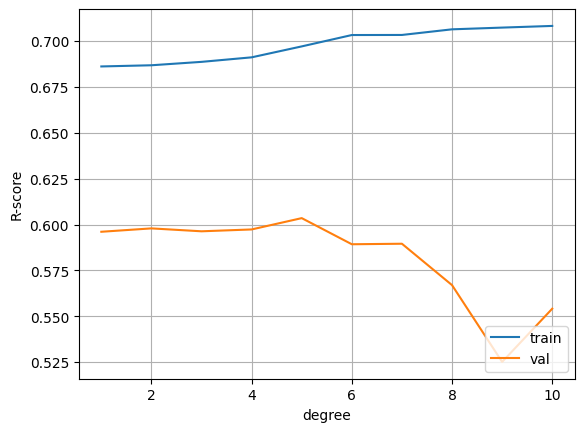

In [76]:
plt.figure()
plt.plot(list(range(1, 11)), polyreg_lst_train, label="train")
plt.plot(list(range(1, 11)), polyreg_lst_test, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("R-score")
plt.grid()
plt.show()

### Regularization

In [77]:
x_val_scaled_cv, x_train_scaled_cv,  y_val_scaled_cv, y_train_scaled_cv = train_test_split(x_train_scaled, y_train_scaled, train_size=0.25, random_state=2)

print('New train Data :', x_train_scaled_cv.shape)
print('New validation Data :', x_val_scaled_cv.shape)
print('New train Data :', y_train_scaled_cv.shape)
print('New validation Data :', y_val_scaled_cv.shape)

New train Data : (300, 2)
New validation Data : (100, 2)
New train Data : (300, 1)
New validation Data : (100, 1)


In [78]:
ridge_train = []
ridge_val = []

for alpha in range(1, 30):
    ridge_model = make_pipeline(PolynomialFeatures(degree = 5), Ridge(alpha))
    ridge_model.fit(x_train_scaled, y_train_scaled)
    ridge_train.append(ridge_model.score(x_train_scaled_cv, y_train_scaled_cv))
    ridge_val.append(ridge_model.score(x_val_scaled_cv, y_val_scaled_cv))

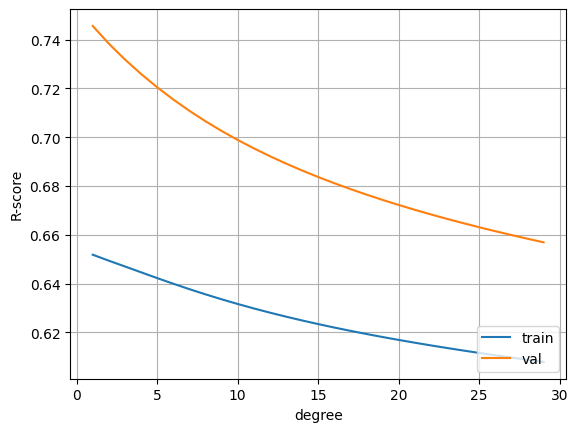

In [79]:
plt.figure()
plt.plot(list(range(1, 30)), ridge_train, label="train")
plt.plot(list(range(1, 30)), ridge_val, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("R-score")
plt.grid()
plt.show()

In [80]:
ridge_train = []
ridge_val = []

for alpha in np.arange(0.1, 3, 0.1):
    ridge_model = make_pipeline(PolynomialFeatures(degree = 5), Ridge(alpha))
    ridge_model.fit(x_train_scaled, y_train_scaled)
    ridge_train.append(ridge_model.score(x_train_scaled_cv, y_train_scaled_cv))
    ridge_val.append(ridge_model.score(x_val_scaled_cv, y_val_scaled_cv))

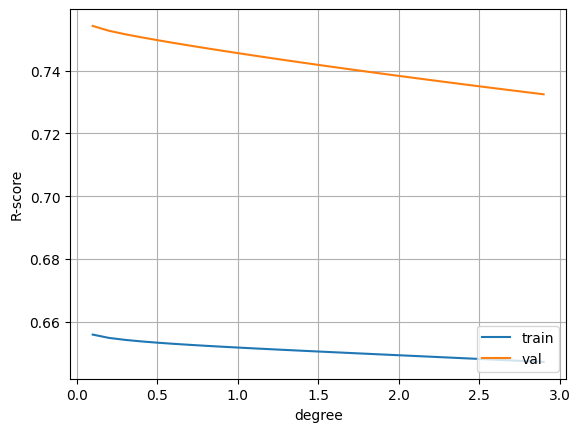

In [81]:
plt.figure()
plt.plot(list(np.arange(0.1, 3, 0.1)), ridge_train, label="train")
plt.plot(list(np.arange(0.1, 3, 0.1)), ridge_val, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("R-score")
plt.grid()
plt.show()

In [82]:
ridge_model = make_pipeline(PolynomialFeatures(degree = 5), Ridge(0.3))
ridge_model.fit(x_train_scaled, y_train_scaled)
print('Ridge Test R2 Score :',ridge_model.score(x_test_scaled, y_test_scaled))

Ridge Test R2 Score : 0.6050420827997904


In [88]:
lasso_train = []
lasso_val = []

for alpha in range(1, 30):
    Lasso_model = make_pipeline(PolynomialFeatures(degree = 5), Lasso(alpha))
    Lasso_model.fit(x_train_scaled_cv, y_train_scaled_cv)
    lasso_train.append(Lasso_model.score(x_train_scaled_cv, y_train_scaled_cv))
    lasso_val.append(Lasso_model.score(x_val_scaled_cv, y_val_scaled_cv))

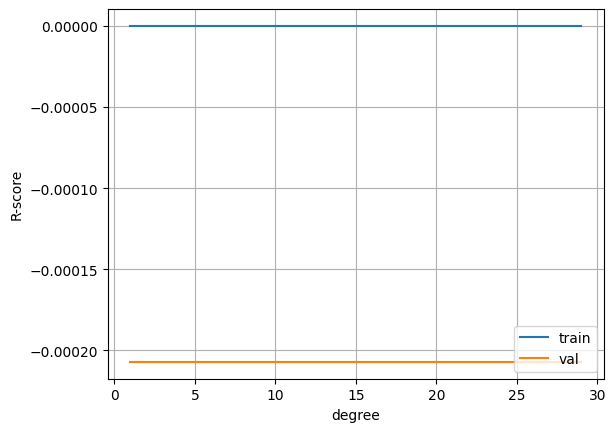

In [89]:
plt.figure()
plt.plot(list(range(1, 30)), lasso_train, label="train")
plt.plot(list(range(1, 30)), lasso_val, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("R-score")
plt.grid()
plt.show()

In [90]:
lasso_train = []
lasso_val = []

for alpha in np.arange(0.1, 3, 0.1):
    Lasso_model = make_pipeline(PolynomialFeatures(degree = 5), Lasso(alpha))
    Lasso_model.fit(x_train_scaled_cv, y_train_scaled_cv)
    lasso_train.append(Lasso_model.score(x_train_scaled_cv, y_train_scaled_cv))
    lasso_val.append(Lasso_model.score(x_val_scaled_cv, y_val_scaled_cv))

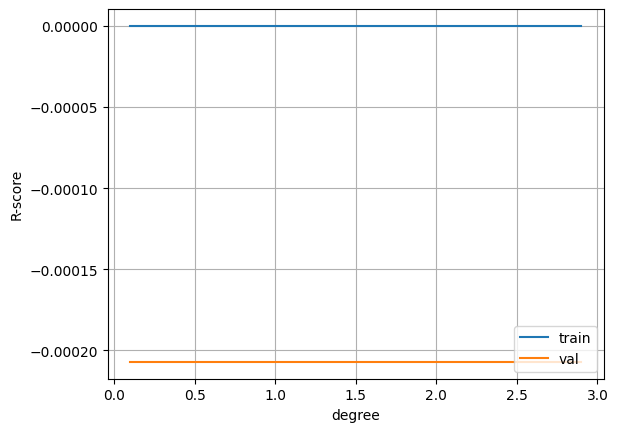

In [91]:
plt.figure()
plt.plot(list(np.arange(0.1, 3, 0.1)), lasso_train, label="train")
plt.plot(list(np.arange(0.1, 3, 0.1)), lasso_val, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("R-score")
plt.grid()
plt.show()

In [92]:
lasso_model = make_pipeline(PolynomialFeatures(degree = 5), Lasso(0.3))
lasso_model.fit(x_train_scaled, y_train_scaled)
print('Ridge Test R2 Score :',lasso_model.score(x_test_scaled, y_test_scaled))

Ridge Test R2 Score : -0.00017338723261683953


## Insights and Recomendations

1. Data is clean and well-managed with no outlier, duplicity or missing values.
2. Dependant variables has high level of Multicollinearity.
3. All the assumptios of linear Regression don't hold true, thus model is not good fit for the data.
4. with Linear regression, correctness will be around 68% for trainig and 59% for test data, indicating low model reliability.
5. with Ridge regularization at alpha 0.3 and Polynomial degree 5 for the feature, model can be trained to achive correctness of ~61%
6. Adding new Features eg: Age, Years of Experience, years from last degree, degree specifics may improve prediction.
7. Better Prediction ability of the model can result into trust in the market, ease in university application process and enhanced consulting services.